In [10]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D 
from dataclasses import dataclass

In [16]:
@dataclass
class LogisticRegression:
    learningRate: float
    maxIteration: int
    epsilon: float
    removePoint: []
       
    def __post_init__(self):
        self.readDataset()
    
    def addX0(self, X):
        """This function add ones to cater the intercept term"""
        return np.column_stack([np.ones(X.shape[0]), X])
        
    def readDataset(self):
        """This function is to load the train test data and split it into X and y values"""
        """Also, column of ones added to cater for intercept term"""
        X_train = pd.read_excel('Lab3_data.xls', sheet_name = '2004--2005 Data')
        X_test = pd.read_excel('Lab3_data.xls', sheet_name = '2004--2007 Data')
               
        X_train = self.remove_index(X_train)
        
        self.y_train = X_train.values[:,0]
        self.y_test = X_train.values[:,0]
        self.X_train = X_train.values[:,1:]
        self.X_test = X_train.values[:,1:]
        self.X_train = self.addX0(self.X_train)
        self.X_test = self.addX0(self.X_test)
        
    
    def remove_index(self, X):
        """This function is for removing any datapoint from the dataset"""
        index_number = [x-1 for x in self.removePoint]
        X = X.drop(index_number)
        return X
        
    def sigmoid(self, z):
        """This is for getting sigmoid function value"""
        sig = 1 / (1 + np.exp(-z))
        return sig 
    
    def costFunction(self, X, y):
        """This will give loss function values, which we have to minimize"""
        sig = self.sigmoid(X.dot(self.w))
        loss = y * np.log(sig) + (1 - y) * np.log(1 - sig)
        cost = - loss.sum()
        return cost 
    
    def gradient(self, X, y):
        """This function will give gradient value of loss function"""
        sig = self.sigmoid(X.dot(self.w))
        return (sig - y).dot(X)
        
    def gradientDescent(self, X, y):
        """This function is for solving the classification problem using gradinet descent"""
        errors = []
        prev_error = float('inf')
        for i in tqdm(range(self.maxIteration), colour = 'red'):
            self.w = self.w - self.learningRate * self.gradient(X, y)
            current_error = self.costFunction(X, y)
            errors.append(current_error)
            
            if np.abs(prev_error - current_error) < self.epsilon:
                """If error between previous iteration and current iteration become less
                than certain value epsilon, model stop learning"""
                print("The model stopped learning")
                break
            prev_error = current_error
            
        self.plot_cost(errors)
        
    def predict(self, X):
        """It will calcuate the probability value for given point and give output 0 or 1
        based on probability is either greater or less than 0.5 respectively"""
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)
    
    def evaluate(self, y, y_hat):
        """This function will convert the classification output into boolean form True or False"""
        y = y == 1
        y_hat = y_hat == 1
        
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()
        f_score = 2 * (precision * recall) / (precision + recall)
        return precision, recall, f_score
    
    def fit(self):
        """This model is to compile all the functions together to update the weight values"""
        self.w = 10 * np.ones(self.X_train.shape[1], dtype=np.float64)
        self.gradientDescent(self.X_train, self.y_train)
        
        y_hat_train  = self.predict(self.X_train)
        precision, recall, f_score = self.evaluate(self.y_train, y_hat_train)
        
        print("The model has precision of {}".format(precision))
        print("The model has recall of {}".format(recall))
        print("The model has F1_score of {}".format(f_score))
        print(self.w)
          
        
    def plot_cost(self,cost_sequence):
        """This function is to plot the cost vs number of itearions"""
        s = np.array(cost_sequence)
        t = np.arange(s.size)
        
        fig, ax = plt.subplots()
        ax.plot(t,s)
        
        ax.set(xlabel = 'iterations', ylabel = 'cost' , title = 'cost trend')
        ax.grid()
        plt.legend(bbox_to_anchor=(1.05,1), loc=2,shadow=True)
        plt.show()
        
       
        
    def plot(self):
        """This function is for plotting the points and their probability value in 3D space """
        plt.figure(figsize=(12,8))
        ax = plt.axes(projection='3d')

        # Data for three-dimensional scattered points
        ax.scatter3D(self.X_train[:, 1], self.X_train[:, 2], 
                     self.sigmoid(self.X_train.dot(self.w)), 
                     c = self.y_train[:], cmap='viridis', s=100);

        ax.set_xlim3d(55, 80)
        ax.set_ylim3d(80, 240)
        plt.xlabel('$x_1$ feature', fontsize=15)
        plt.ylabel('$x_2$ feature', fontsize=15, )
        ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)

    
    
    def scatterPlt(self):
        """This function is used to plot scatter plot in 2D plane with decision boundry surface"""
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w[1:]).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))


        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)


        ax.scatter(self.X_train[:, 1], self.X_train[:, 2], 
                   c=self.y_train[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        plt.xlabel('x1 feature')
        plt.ylabel('x2 feature')
        

    def plot3D(self):
        """This function if to plot the drcision boundry and probabilities in 3D space"""
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240
        
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w[1:]).reshape(xx.shape)
        fig = plt.figure(figsize=(14,12))
        ax = plt.axes(projection='3d')
        ax.contour3D(xx, yy, probs, 50, cmap='binary')

        ax.scatter3D(self.X_train[:, 1], self.X_train[:, 2], 
                   c=self.y_train[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('probs')
        ax.set_title('3D contour')
        plt.show()

  0%|                                              | 0/1000000 [00:00<?, ?it/s]C:\Users\abc\AppData\Local\Temp\ipykernel_4800\2434942999.py:45: RuntimeWarning: divide by zero encountered in log
  loss = y * np.log(sig) + (1 - y) * np.log(1 - sig)
C:\Users\abc\AppData\Local\Temp\ipykernel_4800\2434942999.py:45: RuntimeWarning: invalid value encountered in multiply
  loss = y * np.log(sig) + (1 - y) * np.log(1 - sig)
  2%|▌                              | 19721/1000000 [00:01<01:10, 13807.73it/s]C:\Users\abc\AppData\Local\Temp\ipykernel_4800\2434942999.py:63: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs(prev_error - current_error) < self.epsilon:
  8%|██▎                            | 76013/1000000 [00:04<01:00, 15246.41it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The model stopped learning


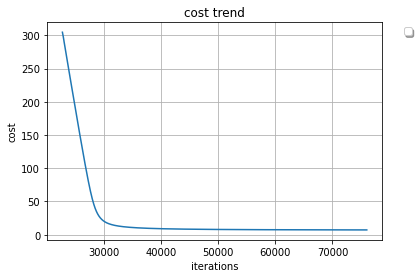

The model has precision of 0.9444444444444444
The model has recall of 0.9444444444444444
The model has F1_score of 0.9444444444444444
[ 9.8095376  -0.70352913  0.27019655]


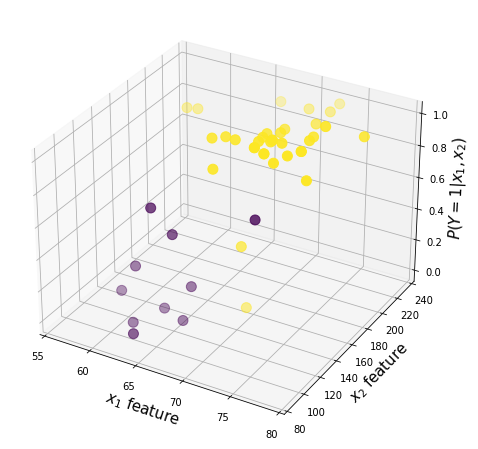

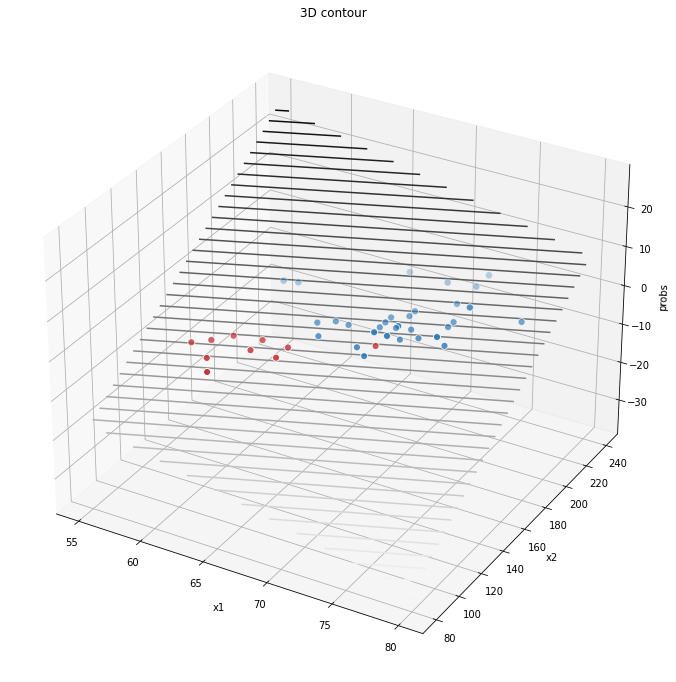

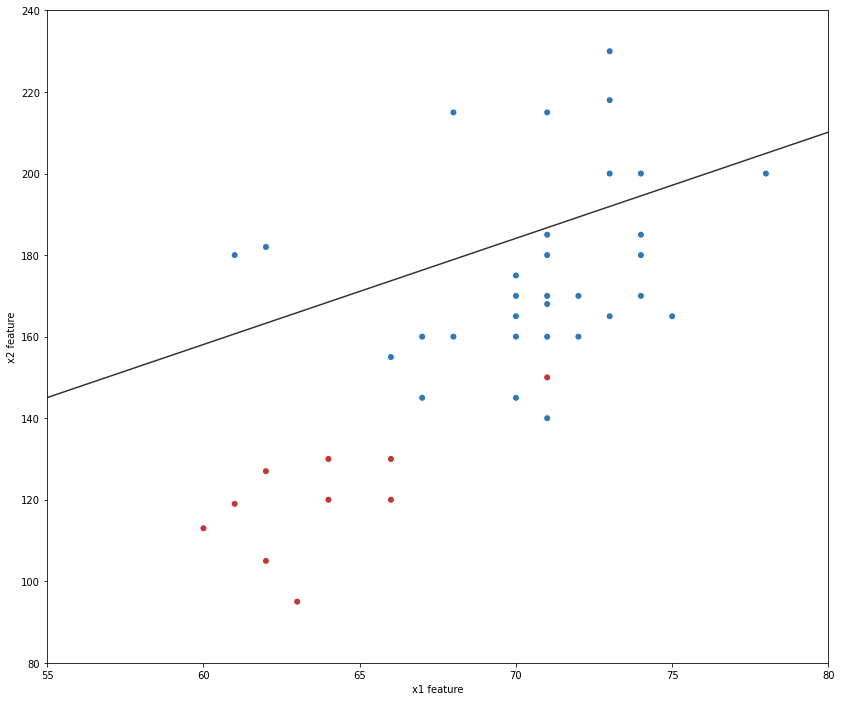

In [17]:
# Training model on basis of training data 
lr = LogisticRegression(epsilon=0.00001, learningRate = 0.1e-5, maxIteration = 1000000, removePoint = [])
lr.fit()
lr.plot()
lr.plot3D()
lr.scatterPlt()

As we see, we get the weights -0.4521 & 0.2193 with respect to x1 and x2 columns and -0.01561 as intercept.  

In [ ]:
[ 0.96643374 -0.47562097  0.22372371]
[ 3.91419018 -0.54859321  0.23778249]
[ 9.8095376  -0.70352913  0.27019655]


 70%|██████████████████████▎         | 69630/100000 [00:04<00:01, 15774.57it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The model stopped learning


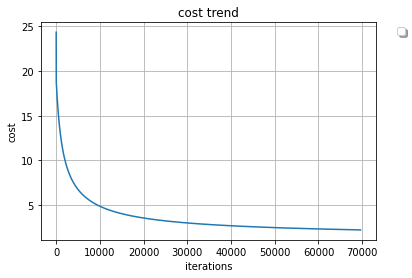

The model has precision of 1.0
The model has recall of 0.9714285714285714
The model has F1_score of 0.9855072463768115
[-0.02064271 -0.61553075  0.2972152 ]


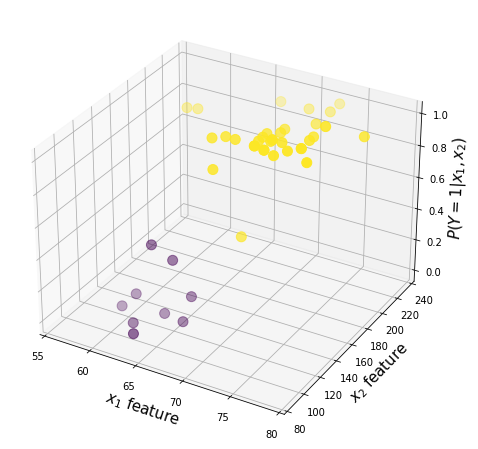

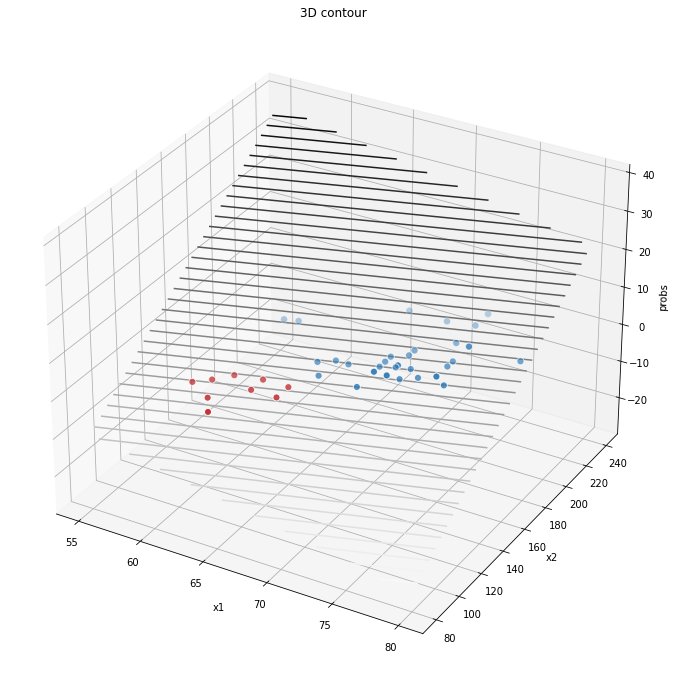

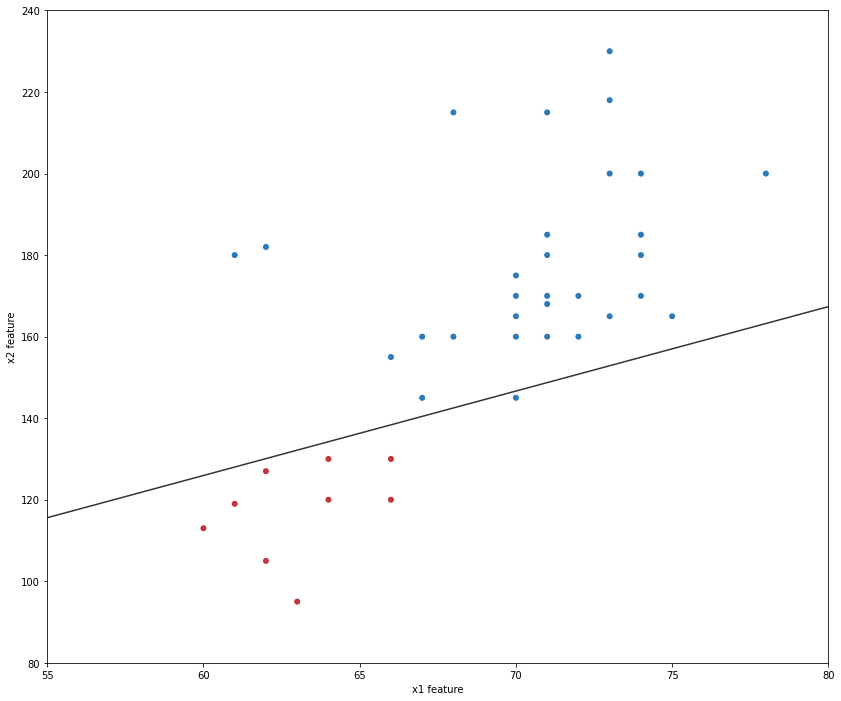

In [43]:
# Removing point 1 and 39 from dataset 
lr = LogisticRegression(epsilon=0.00001, learningRate = 0.1e-5, maxIteration = 100000, removePoint = [1, 39])
lr.fit()
lr.plot()
lr.plot3D()
lr.scatterPlt()

After removing point 1 and 39, weight values changes significantly i.e. -0.6158 and 0.2972 respectively for x1 and x2 variale and -0.02064 as intercept\
This is happening because the datapoints are located very close to decision boundry and so affecting weight values.

 41%|█████████████▏                  | 41041/100000 [00:02<00:03, 16161.10it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The model stopped learning


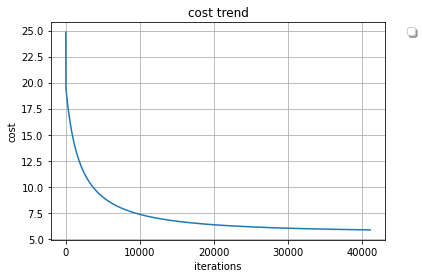

The model has precision of 0.9722222222222222
The model has recall of 0.9722222222222222
The model has F1_score of 0.9722222222222222
[-0.01574701 -0.45174475  0.21924883]


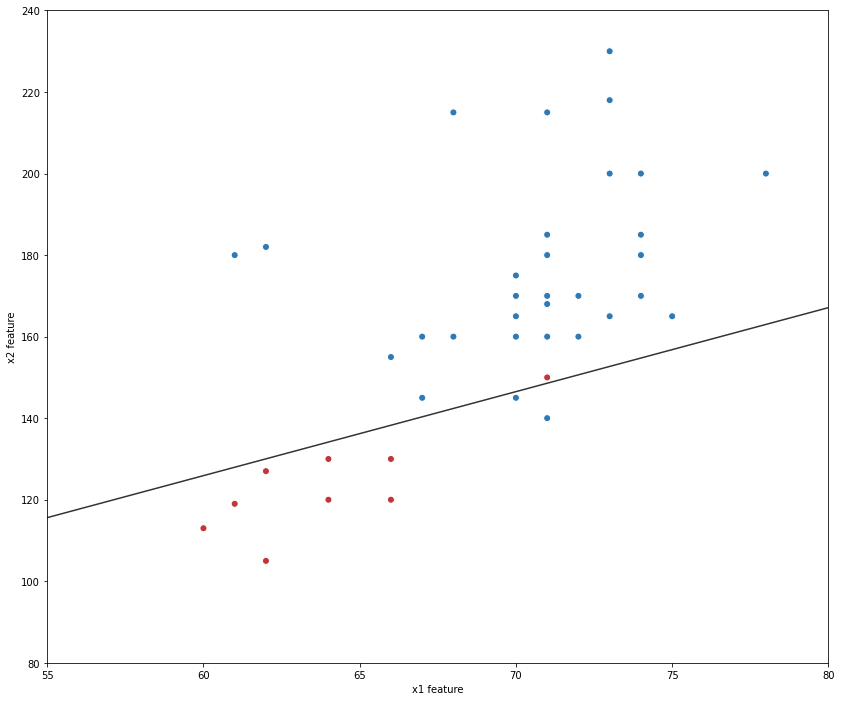

In [44]:
# Remoing point 43 from datset 
lr = LogisticRegression(epsilon=0.00001, learningRate = 0.1e-5, maxIteration = 100000, removePoint = [43])
lr.fit()
lr.scatterPlt()

However, after removing point 43 (index number 42), we can see that weight values change with very minor difference.\
This is because the point is lying far away from decision boundry. \
We know that logistic regression model does not affected by outliers and this can be verified here. 